In [1]:
import sys
sys.path.append('..')

In [2]:
from spinesTS.preprocessing import split_series
from spinesTS.plotting import plot2d
from sklearn.metrics import r2_score

In [3]:
from spinesTS.data import BuiltInSeriesData
from spinesTS.nn import *
from spinesTS.metrics import mean_absolute_error
from spinesTS.metrics import mean_absolute_percentage_error

In [4]:
series_data = BuiltInSeriesData()

+---+----------------------+----------------------------------------------+
|   | table's name         | table's columns                              |
+---+----------------------+----------------------------------------------+
| 0 | ETTh1                | date, HUFL, HULL, MUFL, MULL, LUFL, LULL, OT |
| 1 | ETTh2                | date, HUFL, HULL, MUFL, MULL, LUFL, LULL, OT |
| 2 | ETTm1                | date, HUFL, HULL, MUFL, MULL, LUFL, LULL, OT |
| 3 | ETTm2                | date, HUFL, HULL, MUFL, MULL, LUFL, LULL, OT |
| 4 | Electric_Production  | date, value                                  |
| 5 | Messages_Sent        | date, ta, tb, tc                             |
| 6 | Messages_Sent_Hour   | date, hour, ta, tb, tc                       |
| 7 | Supermarket_Incoming | date, goods_cnt                              |
| 8 | Web_Sales            | date, type_a, type_b, sales_cnt              |
+---+----------------------+----------------------------------------------+


In [5]:
from spinesTS.preprocessing import MultiDimScaler

In [6]:
cs = series_data[0]
cs_data = cs.dataset
from sklearn.preprocessing import MinMaxScaler
mms = MultiDimScaler()
data = cs_data.iloc[:, 1:].values

x_train, x_test, y_train, y_test = split_series(data, cs_data['OT'], 128, 24, train_size=0.9)

x_train = mms.fit_transform(x_train, MinMaxScaler)
x_test = mms.transform(x_test)

In [7]:
x_train.shape, x_test.shape

(torch.Size([15542, 128, 7]), torch.Size([1727, 128, 7]))

In [8]:
cs = series_data[0]
cs_data = cs.dataset
from sklearn.preprocessing import MinMaxScaler
mms = MultiDimScaler()
data = cs_data.iloc[:, 1:].values

x_train, x_test, y_train, y_test = split_series(cs_data['OT'], cs_data['OT'], 64, 24, train_size=0.9)


In [9]:
x_train.shape, x_test.shape

((15599, 64), (1734, 64))

## StackingRNN

Using mps backend
Epoch 1/1000  Loss_Fn mse
488/488 - p0 - loss: 7.6450 - mae: 5.8416 - val_loss: 10.9203 - val_mae: 2.6806 - 9.01s/epoch - 0.018s/step
Epoch 2/1000  Loss_Fn mse
488/488 - p1 - loss: 5.9477 - mae: 4.7546 - val_loss: 12.5210 - val_mae: 2.9103 - 8.63s/epoch - 0.018s/step
Epoch 3/1000  Loss_Fn mse
488/488 - p2 - loss: 5.7984 - mae: 4.8070 - val_loss: 12.6826 - val_mae: 2.9327 - 8.59s/epoch - 0.018s/step
Epoch 4/1000  Loss_Fn mse
488/488 - p3 - loss: 5.1998 - mae: 4.8319 - val_loss: 13.3577 - val_mae: 3.0256 - 8.63s/epoch - 0.018s/step
Epoch 5/1000  Loss_Fn mse
488/488 - p4 - loss: 5.0799 - mae: 4.8803 - val_loss: 13.5071 - val_mae: 3.0461 - 8.64s/epoch - 0.018s/step
Epoch 6/1000  Loss_Fn mse
488/488 - p5 - loss: 5.0104 - mae: 4.8917 - val_loss: 13.5957 - val_mae: 3.0581 - 8.76s/epoch - 0.018s/step
Epoch 7/1000  Loss_Fn mse
488/488 - p6 - loss: 4.9674 - mae: 4.8988 - val_loss: 13.6515 - val_mae: 3.0657 - 8.89s/epoch - 0.018s/step
Epoch 8/1000  Loss_Fn mse
488/488 - p7 - los

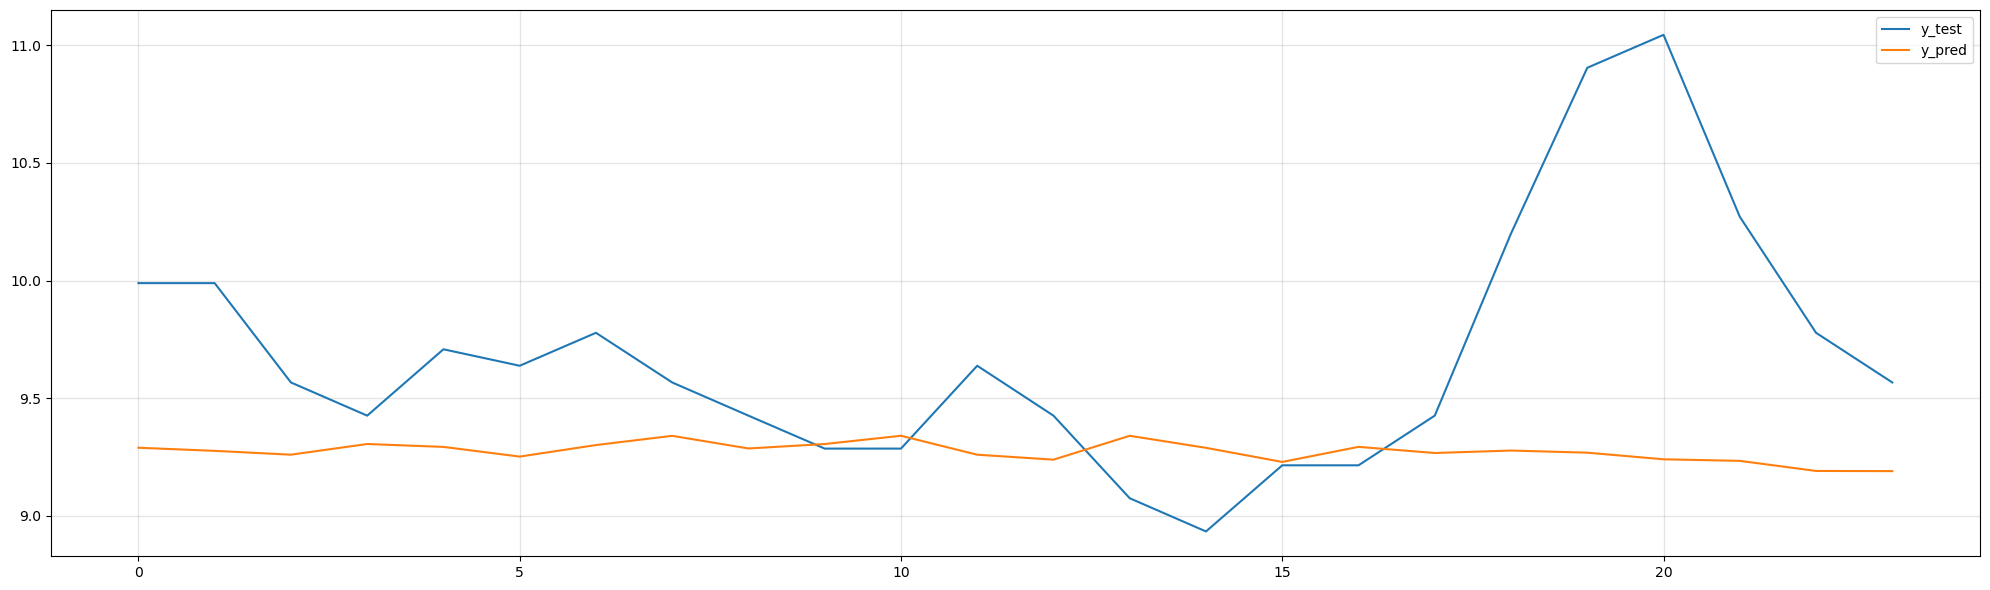

In [10]:
model = StackingRNN(64, 24, random_seed=42, learning_rate=0.01, bidirectional=False, dropout=0.)
model.fit(x_train, y_train, eval_set=(x_test[:-2], y_test[:-2]), batch_size=32,
             min_delta=0, patience=100, epochs=1000, verbose=True, lr_scheduler='ReduceLROnPlateau')
y_pred_cs = model.predict(x_test[-2:])
print(f"r2: {r2_score(y_test[-2:].T, y_pred_cs.T)}")
print(f"mae: {mean_absolute_error(y_test[-2:], y_pred_cs)}")
print(f"mape: {mean_absolute_percentage_error(y_test[-2:], y_pred_cs)}")
a = plot2d(y_test[-2:], y_pred_cs, eval_slices='[-1]', labels=['y_test', 'y_pred'], figsize=(20, 6))

In [ ]:
model = StackingRNN(64, 24, random_seed=42, learning_rate=0.01, bidirectional=False, 
                  dropout=0., num_layers=2, diff_n=1)

from sklearn.preprocessing import StandardScaler

sc_x = StandardScaler()
sc_y = StandardScaler()

x_train_sc = sc_x.fit_transform(x_train)
x_test_sc = sc_x.transform(x_test)

y_train_sc = sc_y.fit_transform(y_train)
y_test_sc = sc_y.transform(y_test)

model.fit(x_train_sc, y_train_sc, eval_set=(x_test_sc[:-2], y_test_sc[:-2]), batch_size=32,
             min_delta=0, patience=100, epochs=1000, verbose=True, lr_scheduler='ReduceLROnPlateau')
y_pred_cs = sc_y.inverse_transform(model.predict(x_test_sc[-2:]))
print(f"r2: {r2_score(y_test[-2:].T, y_pred_cs.T)}")
print(f"mae: {mean_absolute_error(y_test[-2:], y_pred_cs)}")
print(f"mape: {mean_absolute_percentage_error(y_test[-2:], y_pred_cs)}")
a = plot2d(y_test[-2:], y_pred_cs, eval_slices='[-1]', labels=['y_test', 'y_pred'], figsize=(20, 6))

Using mps backend
Epoch 1/1000  Loss_Fn mse
488/488 - p0 - loss: 0.0504 - mae: 0.3478 - val_loss: 0.2525 - val_mae: 0.4353 - 9.01s/epoch - 0.018s/step
Epoch 2/1000  Loss_Fn mse
488/488 - p0 - loss: 0.1917 - mae: 0.3422 - val_loss: 0.0947 - val_mae: 0.2401 - 8.96s/epoch - 0.018s/step
Epoch 3/1000  Loss_Fn mse
488/488 - p1 - loss: 0.1517 - mae: 0.4078 - val_loss: 0.1080 - val_mae: 0.2594 - 8.82s/epoch - 0.018s/step
Epoch 4/1000  Loss_Fn mse
488/488 - p2 - loss: 0.1178 - mae: 0.4444 - val_loss: 0.1262 - val_mae: 0.2851 - 8.79s/epoch - 0.018s/step


## GAUNet

Using mps backend
Epoch 1/1000 
486/486 - p0 - loss: 2.8666 - mae: 3.4761 - val_loss: 3.2458 - val_mae: 3.7340 - 18.61s/epoch - 0.038s/step
Epoch 2/1000 
486/486 - p1 - loss: 3.4077 - mae: 3.2231 - val_loss: 3.9609 - val_mae: 4.4508 - 17.95s/epoch - 0.037s/step
Epoch 3/1000 
486/486 - p2 - loss: 4.1842 - mae: 3.2480 - val_loss: 4.3680 - val_mae: 4.8626 - 18.06s/epoch - 0.037s/step
Epoch 4/1000 
486/486 - p3 - loss: 4.2870 - mae: 3.4497 - val_loss: 4.5951 - val_mae: 5.0900 - 17.89s/epoch - 0.037s/step
Epoch 5/1000 
486/486 - p4 - loss: 4.5560 - mae: 3.2800 - val_loss: 4.5579 - val_mae: 5.0511 - 17.89s/epoch - 0.037s/step
Epoch 6/1000 
486/486 - p5 - loss: 4.3122 - mae: 3.3383 - val_loss: 4.3729 - val_mae: 4.8613 - 18.12s/epoch - 0.037s/step
Epoch 7/1000 
486/486 - p6 - loss: 4.4457 - mae: 3.4389 - val_loss: 4.0900 - val_mae: 4.5794 - 17.74s/epoch - 0.036s/step
Epoch 8/1000 
486/486 - p7 - loss: 4.1274 - mae: 3.2983 - val_loss: 3.9053 - val_mae: 4.3911 - 17.47s/epoch - 0.036s/step
Epoch 

Epoch 57/1000 
486/486 - p8 -  [*lr: 0.004899999999999999] - loss: 0.5140 - mae: 2.2549 - val_loss: 1.1716 - val_mae: 1.6146 - 17.73s/epoch - 0.036s/step
Epoch 58/1000 
486/486 - p9 -  [*lr: 0.004899999999999999] - loss: 0.5857 - mae: 2.3635 - val_loss: 1.1455 - val_mae: 1.5864 - 17.68s/epoch - 0.036s/step
Epoch 59/1000 
486/486 - p10 -  [*lr: 0.004899999999999999] - loss: 0.5466 - mae: 2.2739 - val_loss: 1.2442 - val_mae: 1.6893 - 17.74s/epoch - 0.036s/step
Epoch 60/1000 
486/486 - p11 -  [*lr: 0.004899999999999999] - loss: 0.5734 - mae: 2.2999 - val_loss: 1.1677 - val_mae: 1.6065 - 17.78s/epoch - 0.037s/step
Epoch 61/1000 
486/486 - p0 -  [*lr: 0.004899999999999999] - loss: 0.6102 - mae: 2.4337 - val_loss: 1.0288 - val_mae: 1.4546 - 17.76s/epoch - 0.037s/step
Epoch 62/1000 
486/486 - p1 -  [*lr: 0.004899999999999999] - loss: 0.6341 - mae: 2.3076 - val_loss: 1.1411 - val_mae: 1.5791 - 17.84s/epoch - 0.037s/step
Epoch 63/1000 
486/486 - p2 -  [*lr: 0.004899999999999999] - loss: 0.6397 

Epoch 110/1000 
486/486 - p11 -  [*lr: 0.0011764899999999994] - loss: 0.5680 - mae: 1.8615 - val_loss: 0.8693 - val_mae: 1.2741 - 17.80s/epoch - 0.037s/step
Epoch 111/1000 
486/486 - p12 -  [*lr: 0.0011764899999999994] - loss: 0.5625 - mae: 1.8593 - val_loss: 0.8746 - val_mae: 1.2801 - 17.84s/epoch - 0.037s/step
Epoch 112/1000 
486/486 - p13 -  [*lr: 0.0011764899999999994] - loss: 0.5604 - mae: 1.8606 - val_loss: 0.8784 - val_mae: 1.2846 - 17.81s/epoch - 0.037s/step
Epoch 113/1000 
486/486 - p14 -  [*lr: 0.0011764899999999994] - loss: 0.5621 - mae: 1.8617 - val_loss: 0.8807 - val_mae: 1.2871 - 17.81s/epoch - 0.037s/step
Epoch 114/1000 
486/486 - p15 -  [*lr: 0.0011764899999999994] - loss: 0.5648 - mae: 1.8621 - val_loss: 0.8816 - val_mae: 1.2881 - 17.89s/epoch - 0.037s/step
Epoch 115/1000 
486/486 - p16 -  [*lr: 0.0011764899999999994] - loss: 0.5667 - mae: 1.8622 - val_loss: 0.8817 - val_mae: 1.2882 - 17.86s/epoch - 0.037s/step
Epoch 116/1000 
486/486 - p17 -  [*lr: 0.00117648999999999

Epoch 163/1000 
486/486 - p64 -  [*lr: 0.00019773267429999984] - loss: 0.4868 - mae: 1.7366 - val_loss: 0.8447 - val_mae: 1.2506 - 17.80s/epoch - 0.037s/step
Epoch 164/1000 
486/486 - p65 -  [*lr: 0.00019773267429999984] - loss: 0.4863 - mae: 1.7311 - val_loss: 0.8415 - val_mae: 1.2471 - 17.74s/epoch - 0.037s/step
Epoch 165/1000 
486/486 - p66 -  [*lr: 0.00019773267429999984] - loss: 0.4857 - mae: 1.7278 - val_loss: 0.8398 - val_mae: 1.2451 - 17.82s/epoch - 0.037s/step
Epoch 166/1000 
486/486 - p67 -  [*lr: 0.00019773267429999984] - loss: 0.4853 - mae: 1.7257 - val_loss: 0.8388 - val_mae: 1.2440 - 17.73s/epoch - 0.036s/step
Epoch 167/1000 
486/486 - p68 -  [*lr: 0.00019773267429999984] - loss: 0.4851 - mae: 1.7242 - val_loss: 0.8381 - val_mae: 1.2432 - 17.77s/epoch - 0.037s/step
Epoch 168/1000 
486/486 - p69 -  [*lr: 0.00019773267429999984] - loss: 0.4848 - mae: 1.7231 - val_loss: 0.8376 - val_mae: 1.2426 - 17.92s/epoch - 0.037s/step
Epoch 169/1000 
486/486 - p70 -  [*lr: 0.00019773267

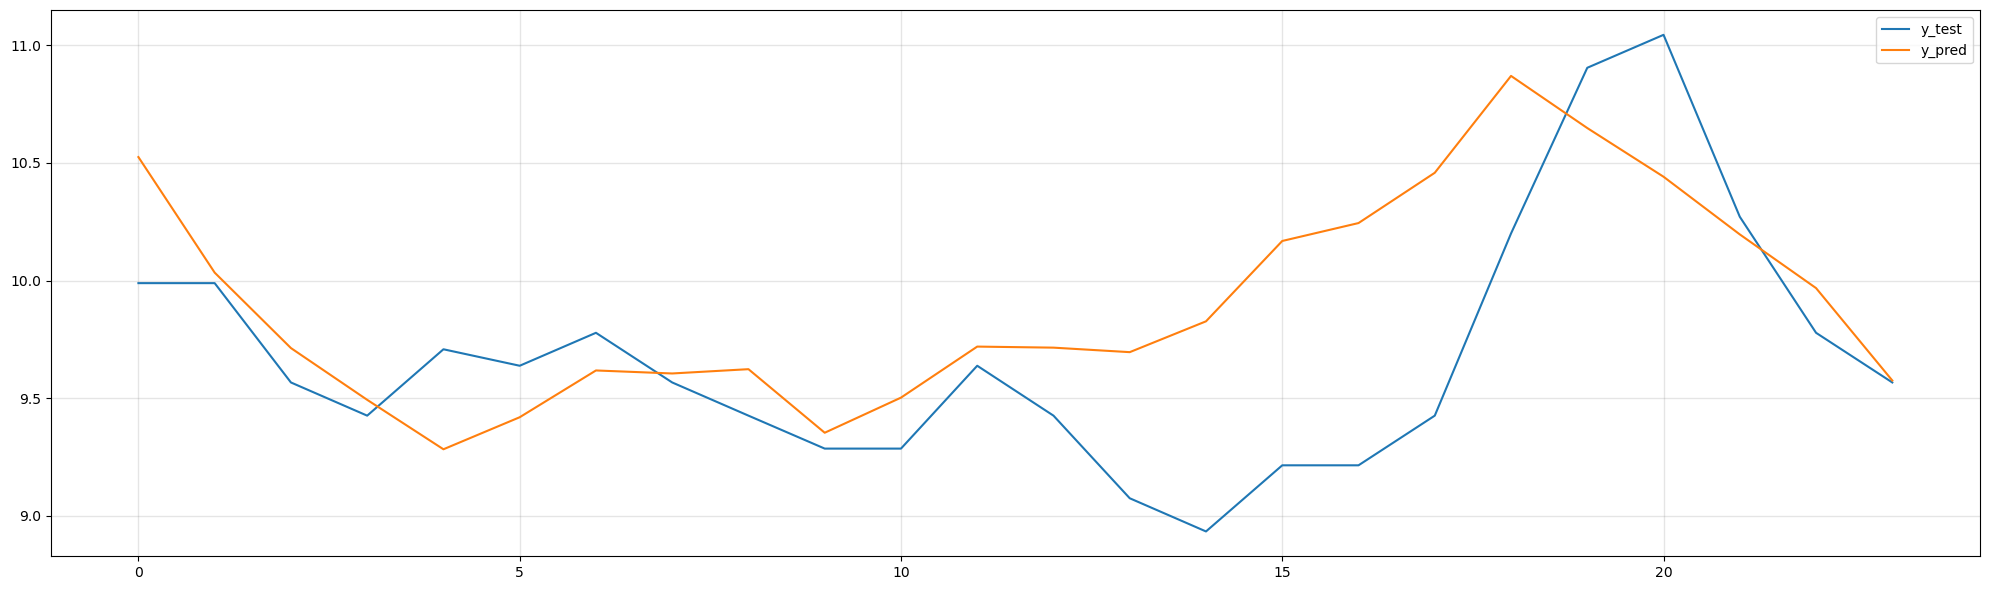

In [7]:
model = GAUNet((128, 7), 24, random_seed=42, flip_features=False, learning_rate=0.01, level=5)
model.fit(x_train, y_train, eval_set=(x_test[:-2], y_test[:-2]), batch_size=32,
             min_delta=0, patience=100, epochs=1000, verbose=True, lr_scheduler='ReduceLROnPlateau')
y_pred_cs = model.predict(x_test[-2:])
print(f"r2: {r2_score(y_test[-2:].T, y_pred_cs.T)}")
print(f"mae: {mean_absolute_error(y_test[-2:], y_pred_cs)}")
print(f"mape: {mean_absolute_percentage_error(y_test[-2:], y_pred_cs)}")
a = plot2d(y_test[-2:], y_pred_cs, eval_slices='[-1]', labels=['y_test', 'y_pred'], figsize=(20, 6))

r2: -2.0887437713462678
mae: 1.2237066809872452
mape: 0.13840103002560572


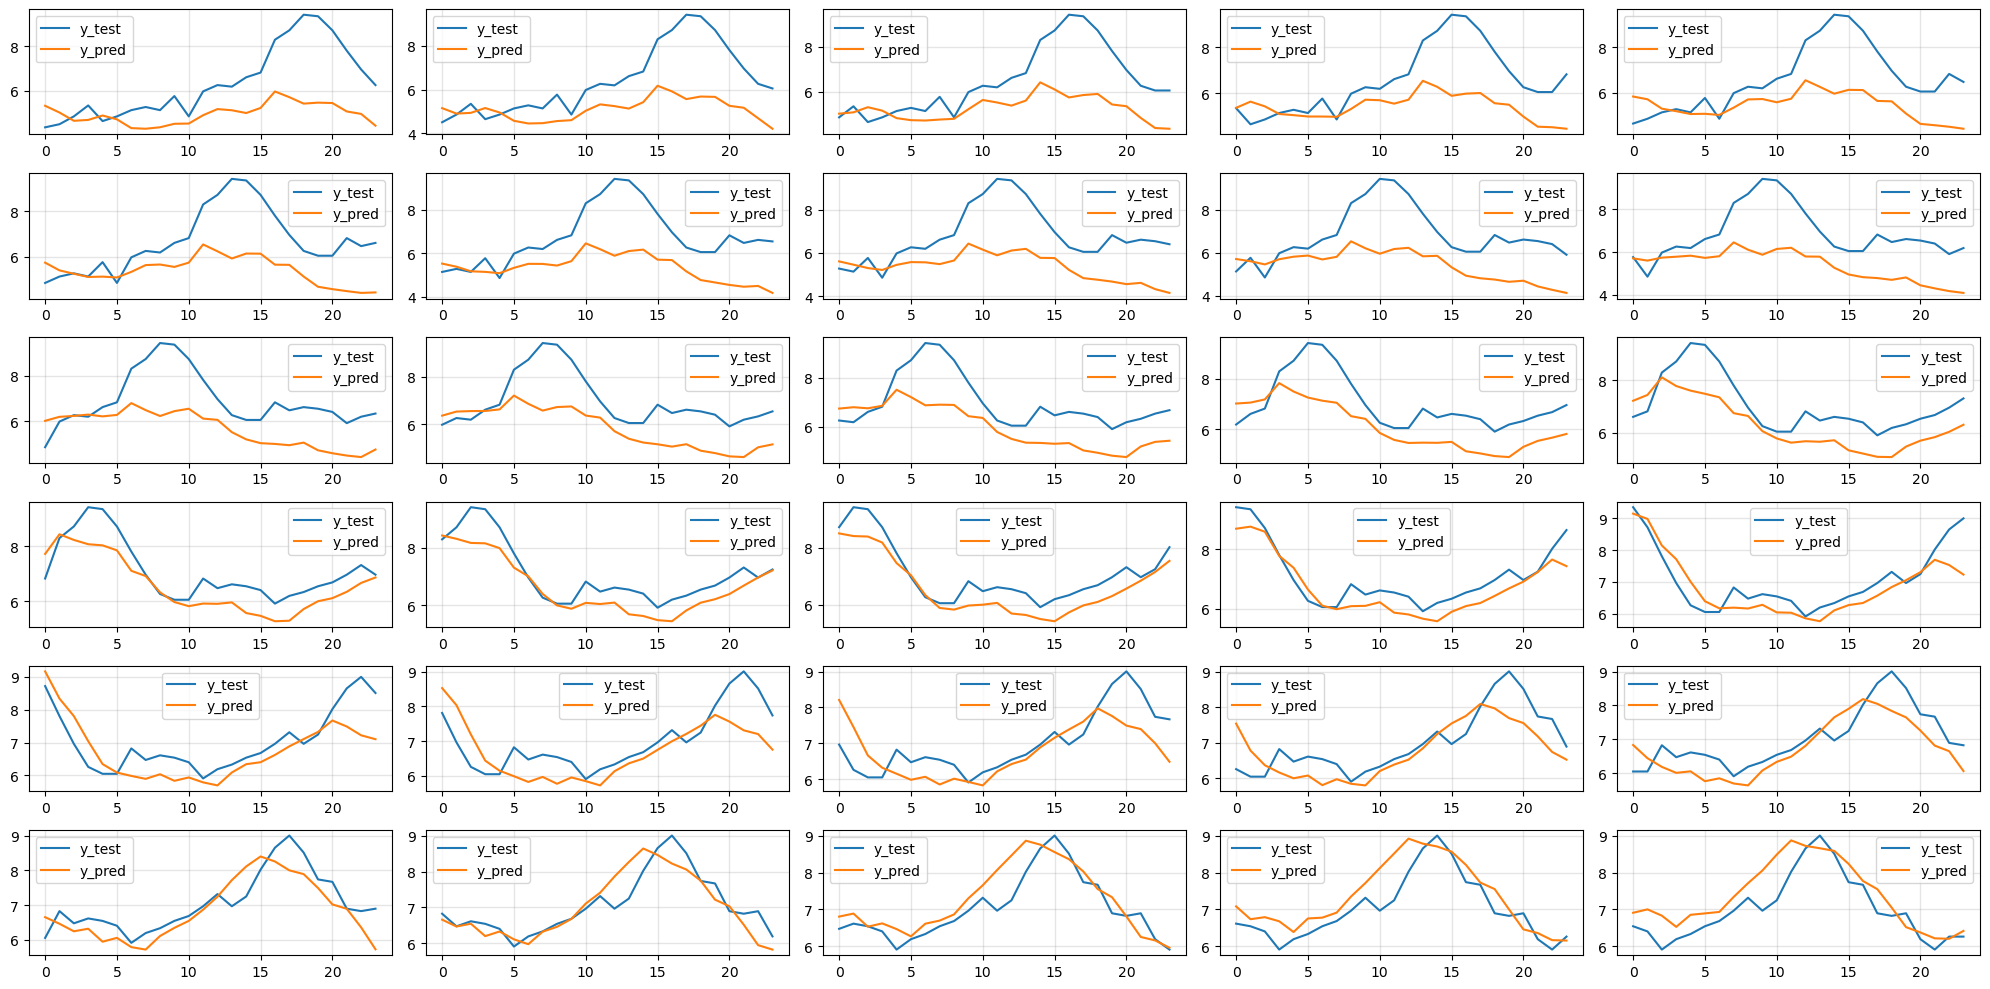

In [8]:
y_pred_cs = model.predict(x_test)
print(f"r2: {r2_score(y_test.T, y_pred_cs.T)}")
print(f"mae: {mean_absolute_error(y_test, y_pred_cs)}")
print(f"mape: {mean_absolute_percentage_error(y_test, y_pred_cs)}")
a = plot2d(y_test, y_pred_cs, eval_slices='[:30]', labels=['y_test', 'y_pred'], figsize=(20, 10))